## Derivative based graph learning in P-regime 

In [2]:
%pylab inline
import pandas as pd
import matlab
import matlab.engine
MATLAB = matlab.engine.start_matlab()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### P regime, N=50 Nodes
The set of functions $M$ for P-regime of networks:
$$
    M = (M_0, M_1,M_2) = (-(\cdot)^{0.5} , 1, (\cdot)^{0.2})
$$

Central equation for node $i$:
$$
\frac{dx_{i}}{dt} = - x_{i}^{0.5} + \sum_{j=1}^{N} A_{ij} x_{j}^{0.2}
$$

Vectorized and using power notation:

$$
\frac{d \vec{x}}{dt} = - \vec{x}^{0.5} + I_{N \times N} A \vec{x}^{0.2}
$$

We will evolve the system as per the above equation with the following adjacency matrix:

In [3]:
N = 21
T =10000
A_gt = abs(rand(N,N))
for i in range(N): A_gt[i,i] = 0
A_gt = (A_gt + A_gt.T)/2

In [4]:
A_gt, A_gt - A_gt.T
# checking if the ground truth matrix is symmetric

(array([[0.        , 0.38084512, 0.86718107, 0.37224868, 0.25796675,
         0.10449749, 0.34084194, 0.59413951, 0.10423829, 0.55516365,
         0.82679494, 0.70715274, 0.48371882, 0.68702227, 0.82541649,
         0.02894699, 0.60735182, 0.25574291, 0.41224824, 0.55349582,
         0.93655845],
        [0.38084512, 0.        , 0.58009582, 0.60919837, 0.8542557 ,
         0.73137861, 0.53198172, 0.65011378, 0.67572481, 0.75400345,
         0.61168355, 0.36911568, 0.34393513, 0.26758712, 0.2870202 ,
         0.72574643, 0.64722636, 0.27747281, 0.61954431, 0.2379748 ,
         0.55097311],
        [0.86718107, 0.58009582, 0.        , 0.53411225, 0.56045736,
         0.36880733, 0.33027355, 0.79562575, 0.73253068, 0.21297578,
         0.56816675, 0.40320156, 0.53912555, 0.28429825, 0.08483523,
         0.75460298, 0.68897233, 0.0343112 , 0.34036491, 0.35367763,
         0.47206969],
        [0.37224868, 0.60919837, 0.53411225, 0.        , 0.07503311,
         0.17721532, 0.25637562, 0.32

In [5]:
dt = 0.001
x0 = abs(randn(N,))
x0
#  setting up initial conditions and the time resolution

array([1.16772582, 0.39757913, 0.66459298, 0.0601471 , 1.471091  ,
       0.98040353, 0.16206257, 0.95789907, 0.47455535, 0.55714724,
       0.94930723, 0.48470885, 1.41045588, 0.04198504, 1.21036434,
       0.75908886, 0.73606657, 0.84114719, 0.13701515, 1.14226779,
       0.46010253])

In [6]:
x = x0
Traj = []

for i in range(T):
    Traj.append(x)
    x = x + (-(x)+ dot(A_gt,(x)/(1+x)))*dt

### Issue
The value of the graph signal depends on the previous update, and the 'how' is dictated by the differential equation
But the first term, $\vec{x}^{0.5}$ will throw some errors in our simulation if any of the components of $\vec{x}$ are negative. 

A quick fix was to take the absolute value before applying the square root.

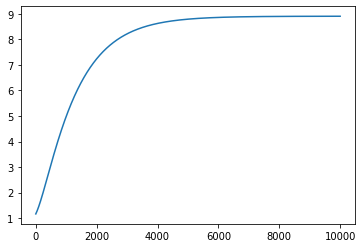

In [7]:
plot([(Traj[i])[0] for i in range(T)])

In [8]:
xp = [Traj[i][0] for i in range(T)]
x_0 = matlab.double(xp)
MATLAB.plot(x_0)

In [9]:
x1 =  [Traj[i][1] for i in range(T)]
x_1 = matlab.double(x1)

x2 =  [Traj[i][2] for i in range(T)]
x_2 = matlab.double(x2)

x3 =  [Traj[i][3] for i in range(T)]
x_3 = matlab.double(x3)

x4 =  [Traj[i][4] for i in range(T)]
x_4 = matlab.double(x4)

In [10]:
MATLAB.workspace['ex0'] = x_0
MATLAB.workspace['ex1'] = x_1
MATLAB.workspace['ex2'] = x_2
MATLAB.workspace['ex3'] = x_3
MATLAB.workspace['ex4'] = x_4

In [11]:
MATLAB.eval("var1 = [ex0; ex1; ex2; ex3; ex4];",nargout = 0)
MATLAB.eval("for k = 1:5 subplot(3,2,k); plot(var1(k,:)); end",nargout = 0)

We will now try to learn back the coefficients of A using some Matrix inversion;

For different samples in `Traj` which track the movement of the signal at all nodes, we will take N such samples and compute the finite difference based derivative and set it equal to the affine  RHS of the central equation evaluated at that point in time (we will use left hand derivative)

In [12]:
k = 2
samples = [Traj[k*i] for i in range(T//k)]
derivs = [(samples[i+1] - samples[i])/(k*dt) for i in range(T//k - 1)]
# larger timescale used

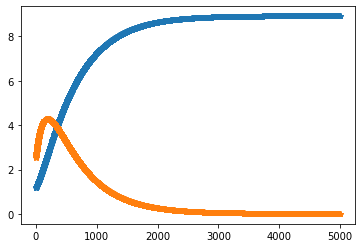

In [13]:
plot(array(samples)[:,0],"*")
plot([i for i in range(T//k - 1)], array(derivs)[:,0],"*")

We have many equations of the form 
$$
\frac{\vec{x}_{i+1} - \vec{x}_{i}}{t_{i+1} - t_{i}} = -\sqrt{\vec{x}_{i}} + A \sqrt[5]{\vec{x}_{i}} \\
$$

$$
\frac{\vec{x}_{i+1} - \vec{x}_{i}}{t_{i+1} - t_{i}} + \sqrt{\vec{x}_{i}} =  A \sqrt[5]{\vec{x}_{i}} \\
$$
$$
\vec{v}_{i} = A \vec{u}_{i}
$$

To solve this, we can simply adjoin different instances of the above so that it forms:

$$
 V = AU
$$


where U, V are both NxN matrices (columns of U,V follow the first equation)
This means, using N instances of first eq we can try to get back the Matrix A.

$$
U = [\vec{u}_1 \vec{u}_2 \dots \vec{u}_N]
$$

$$
V = [\vec{v}_1 \vec{v}_2 \dots \vec{v}_N]
$$

In [35]:
M = N
V = zeros((N,M))
U = zeros((N,M))

for ind, i in enumerate(randint(0,T/k, M)):
    V[:,ind] =  derivs[i] + samples[i]
    U[:,ind] = (samples[i])/(1+(samples[i]))

### Trying with NC2 equations instead

Trying to unravel Adjacency matrix into a vector instead: 

Adjacency has symmetric structure, which means the equations would look like so:

$$
A \vec{u} = 
\begin{bmatrix}
0 \quad w_{12} \quad w_{13} \dots w_{1N} \\
w_{21}  \quad 0  \quad w_{23}  \dots w_{2N}\\
\vdots \quad \vdots \quad \ddots \quad \dots \quad \vdots \\
w_{N1} \quad w_{N2} \quad w_{N3}  \dots 0\\
\end{bmatrix}  
\begin{bmatrix} 
u_1 \\
u_2 \\
u_3 \\
\vdots
\end{bmatrix}  
= u_1 \cdot
\begin{bmatrix} 
0 \\
w_{21} \\
w_{31} \\
\vdots 
\end{bmatrix}  
+
u_2 \cdot
\begin{bmatrix} 
w_{12} \\
0 \\
w_{32} \\
\vdots 
\end{bmatrix} 
\dots 
+
u_N \cdot
\begin{bmatrix} 
w_{1N} \\
\vdots  \\
w_{N-1 N} \\
0 
\end{bmatrix} 
$$

A is of order $N \times N$, but imformation it stores is captured in $\frac{N^2 - N}{2}$

Unraveling the Adjacency matrix mean we only keep track of each pair of nodes, and what the weight of connecting edge is:

If we pre-index;
-   1 -> 1,2
-   1 -> 1,3
-   ...
-   1 -> 1,N
-   2 -> 2,3
-   2 -> 2,4
and so on till 
-   N-1 -> N

How would $\vec{u}$ change accordingly?
We can notice that $w_{ij} = w_{ji}$ and they only show up in the linear combination of i, jth columns, which means they are scaled by $u_{i} + u_{j}$ Thus, we can simply convert $\vec{u}_{N\times 1} \to \vec{\tilde{u}}_{\frac{N^2 - N}{2}\times 1} $ where each entry of $\vec{\tilde{u}}$ follows the indexing shown above; This transformation can help us compute back the Adjacency because now we just have to produce $\vec{\tilde{u}}^{T} \vec{\tilde{A}}$

Where $\vec{\tilde{A}}$ = weights in indexing mentioned above;
 

## Getting the structure of U
Consider :
$$
    A \vec{u} = \vec{v}
$$
where A is of the form 
$$
A = 
\begin{bmatrix}
0      &  \quad a_{12}  & \quad a_{13}  &  \dots  & a_{1 N-1} &  \quad a_{1N}    \\
a_{12} &  \quad 0       & \quad a_{23}  &  \dots & a_{2 N-1} & \quad a_{2N}    \\
a_{13} &  \quad a_{23}  & \quad 0       &  \dots & a_{3 N-1} & \quad a_{3N}    \\
\vdots &  \quad \vdots & \quad \vdots   & \ddots &\vdots    & \quad \vdots    \\
a_{1N-1} & \quad a_{2N-1}&\quad a_{3N-1}&  \dots & 0        & \quad a_{N-1 N} \\ 
a_{1N}  & \quad a_{2N} & \quad a_{3N}   & \dots & a_{N-1 N} & \quad 0         \\
\end{bmatrix}  
$$

and hence,

$$
\begin{bmatrix}
0      &  \quad a_{12}  & \quad a_{13}  &  \dots  & a_{1 N-1} &  \quad a_{1N}    \\
a_{12} &  \quad 0       & \quad a_{23}  &  \dots & a_{2 N-1} & \quad a_{2N}    \\
a_{13} &  \quad a_{23}  & \quad 0       &  \dots & a_{3 N-1} & \quad a_{3N}    \\
\vdots &  \quad \vdots & \quad \vdots   & \ddots &\vdots    & \quad \vdots    \\
a_{1N-1} & \quad a_{2N-1}&\quad a_{3N-1}&  \dots & 0        & \quad a_{N-1 N} \\ 
a_{1N}  & \quad a_{2N} & \quad a_{3N}   & \dots & a_{N-1 N} & \quad 0         \\
\end{bmatrix}   
\begin{bmatrix} 
u_1 \\
u_2 \\
u_3 \\
\vdots \\
u_{N-1} \\
u_{N}
\end{bmatrix}  
=
\begin{bmatrix} 
v_1 \\
v_2 \\
v_3 \\
\vdots \\
v_{N-1} \\
v_{N}
\end{bmatrix}  \\ 
\implies
u_1 
\begin{bmatrix}
0      \\
a_{12} \\
a_{13} \\
\vdots \\
a_{1N-1}\\
a_{1N} \\
\end{bmatrix}
+
u_2
\begin{bmatrix}
a_{12} \\
0       \\
a_{23}  \\
\vdots \\
a_{2N-1}\\
a_{2N}    \\
\end{bmatrix}
+
\dots 
+
u_N
\begin{bmatrix}
 a_{1N}    \\
a_{2N}    \\
a_{3N}    \\
\vdots    \\
a_{N-1 N} \\ 
0         \\
\end{bmatrix}
=
\begin{bmatrix} 
v_1 \\
v_2 \\
v_3 \\
\vdots \\
v_{N-1} \\
v_{N}
\end{bmatrix} \\
$$
Let us vectorize A as follows:
$$
\vec{A} = 
\begin{bmatrix}
a_{12} \\
a_{13} \\
\vdots \\
a_{1N} \\
a_{23} \\
a_{24} \\
\vdots \\
a_{2N} \\
a_{34} \\ 
\vdots \\
\vdots \\
a_{N-2 N-1} \\
a_{N-2 N} \\
a_{N-1 N}
\end{bmatrix} 
_{\frac{N(N-1)}{2} \times 1}
$$

Now, for Au = v, we have to write u as a matrix such that
$$
U_{N \times {\frac{N(N-1)}{2}}} \vec{A} = \vec{v}
$$


We can see that the matrix follows a structure according to the previous equations (ui, uj only appear as coefficient of aij terms), thus, U can be realised as a matrix in a recursive block manner as follows

<!-- $$
U = 
\begin{bmatrix}
\textbf{0}_{i-1 \times N-i} & | \\  
u((i+1:N)) & |\\
u_{i} I_{N-i} & |
\end{bmatrix}_{i = 1}^{N-1}
$$ -->

$$
U  = 
\begin{bmatrix}
\textbf{0}_{i-1 \times N-i}  & \rule[-1mm]{0.4mm}{0.5cm} &^{N-1}  \\   
\rule{2.5cm}{0.4pt} & \rule[-1mm]{0.4mm}{0.5cm} &\\  
u((i+1:N))  &\rule[-1mm]{0.4mm}{0.5cm} & \\
\rule{2.5cm}{0.4pt} & \rule[-1mm]{0.4mm}{0.5cm} & \\
u_{i} I_{N-i} & \rule[-1mm]{0.4mm}{0.5cm} &_{i = 1}\\
\end{bmatrix}
$$


In [36]:
def U_synth(u):
    N = u.shape[0]
    for i in range(1,N):

        if i == 1:
            uL = u[i:,:].T
            I = u[i-1,:]*eye(N-i)
            t = append(uL,I,axis=0)
            U = t
        
        else:
            Z = zeros((i-1,N-i))
            uL = u[i:,:].T
            I = u[i-1,:]*eye(N-i)
            t = append(Z,uL,axis=0)
            t = append(t,I,axis=0)    
            U = append(U,t, axis=1)
    return U

In [37]:
num_sample = (N-1)//2
u = reshape(U[:,0], (N,1))
v = V[:,0]
Bigu = U_synth(u)
vV = v

Bigu1 = U_synth(u)
vV1 = v

for k in range(1,M):
    Bigu = append(Bigu, U_synth(reshape(U[:,k], (N,1))), axis=0)
    vV = append(vV, V[:,k], axis = 0)


for k in random.permutation(M):
    Bigu1 = append(Bigu1, U_synth(reshape(U[:,k], (N,1))), axis=0)
    vV1 = append(vV1, V[:,k], axis = 0)


In [38]:
A_vec_try = dot(pinv(Bigu), vV)
A_vec_try_1 = dot(pinv(Bigu1), vV1)

In [39]:
def vectorizer(M):
    N = M.shape[0]
    vec = M[1:,0]
    for i in range(1,N):  
        vec = append(vec, M[i+1:,i], axis = 0)
    return vec

def matricizer(vec):
    N = vec.shape[0]
    N = int((1+np.sqrt(1+8*N))//2)
    M = zeros((N,N))
    k1 = 0
    k2 = N-1
    for i in range(N):
        s = N - i-2
        M[i+1:,i] = vec[k1:k2]
        k1 = k2 
        k2 += s
    return M + M.T

In [40]:
A = matlab.double(Bigu.tolist())
MATLAB.workspace['ww'] = A
MATLAB.eval("rank(ww)")

126.0

In [41]:
AAAA = matricizer(A_vec_try)
AAAA_1 = matricizer(A_vec_try_1)
Bigu.shape

(441, 210)

2.2730755938971696e+16

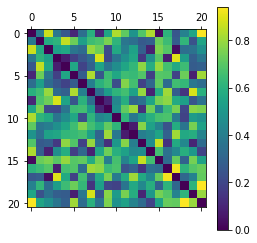

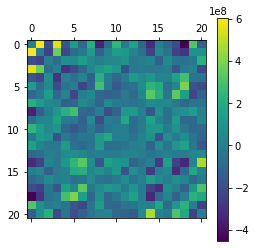

In [42]:
matshow(A_gt) 
colorbar()
matshow(AAAA) 
colorbar()
average((A_gt-AAAA)**2)
# colorbar()

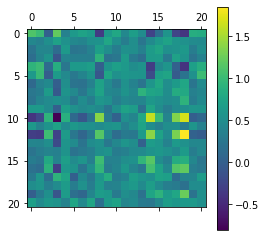

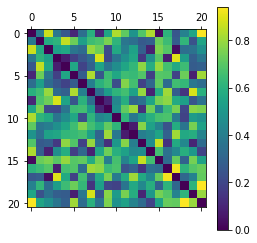

In [43]:
A_new = (dot(V[:2*N], pinv(U[:2*N])))
matshow(A_new)
colorbar()
matshow(A_gt)
colorbar()
# norm()

(0.7615722713659191, 85.8221916801609, 85.55039844853799, 0.10348422400809887)

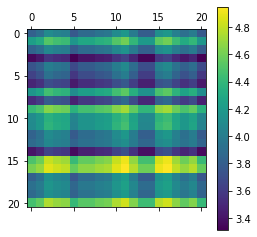

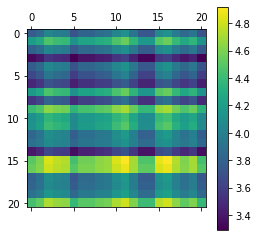

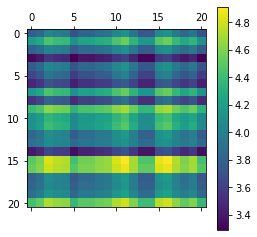

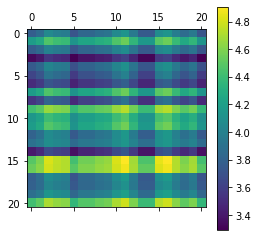

In [44]:
# norm(matricizer(A_vec_try).dot(U) - V)
matshow(dot(AAAA,U))
colorbar()
matshow(V)
colorbar()
matshow(dot(A_gt,U))
colorbar()
matshow(dot(AAAA_1,U))
colorbar()
norm(dot(AAAA,U)-V), norm(dot(AAAA,U)), norm(V), norm(dot(A_gt,U)-V)

In [45]:
A_gt_mat = matlab.double(A_gt.tolist())
MATLAB.workspace["aa"] = A_gt_mat
MATLAB.eval("rank(aa)")

21.0

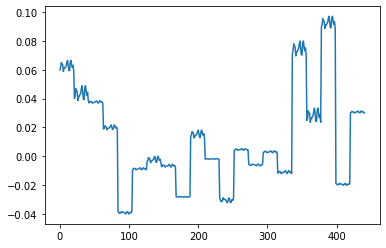

In [46]:
plot((dot(AAAA,U) -V).flatten())
# colorbar()

In [47]:
norm(A_vec_try - A_vec_try_1), norm(AAAA - AAAA_1)

(5174228109.28517, 7317463566.963183)

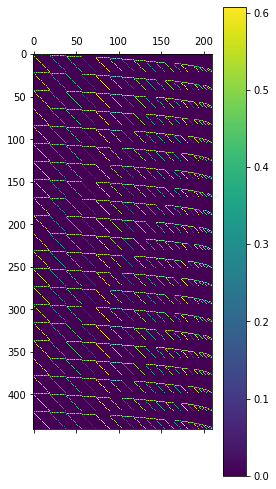

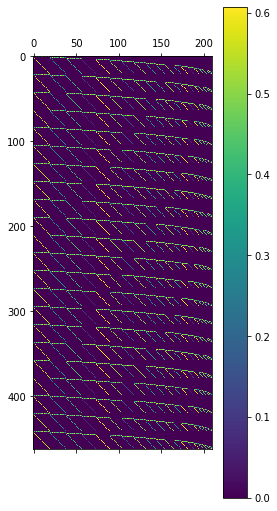

In [48]:
matshow(Bigu)
colorbar()
matshow(Bigu1)
colorbar()

In [49]:
linalg.matrix_rank(Bigu), shape(Bigu)

(125, (441, 210))

In [50]:
linalg.matrix_rank(Bigu1), shape(Bigu1)

(125, (462, 210))

2.432376777795247e-15

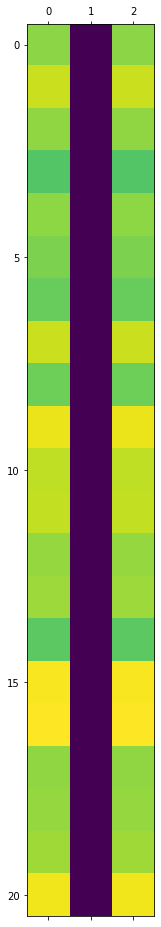

In [51]:
q = (dot(A_gt,u))
p = (dot(U_synth(u),vectorizer(A_gt))).reshape((21,1))
# matshow(hstack((q,p)))

Q = append(q,zeros((21,1)),axis=1)
Q = append(Q,p,axis=1)

matshow(Q)
norm(q-p)

In [52]:
r = linalg.matrix_rank 
r(A_gt) , r(U[:,:N]), r(V[:,:2*N])

(21, 7, 7)

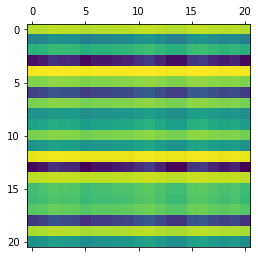

In [53]:
matshow(U[:,:50])